In [1]:
import torch
import pandas as pd
import numpy as np
import random 
import math
from tqdm import tqdm
from IPython.display import clear_output
import itertools 
import operator
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LinearLocator, AutoMinorLocator

import seaborn as sns
from scipy import stats
from copy import deepcopy
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from statsmodels.stats.multitest import multipletests


/Users/nikolaibeckjensen/Company2Vec/myenv2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

subset_versions = ["0", "11" , "13", "18"]
save_path = r".../analysis/plots/%s/" 
data_path = r"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/embeddings/final_pretrained/tensors_idx%s.tsv"
vocab_path = r"/Users/nikolaibeckjensen/Library/CloudStorage/OneDrive-DanmarksTekniskeUniversitet/Virk2Vec/data/processed/vocab/global_set/result.tsv"
paths = [data_path %sv for sv in subset_versions]
vocab = pd.read_csv(vocab_path, sep="\t")


In [3]:
def upper(df):
    '''Returns the upper triangle of a correlation matrix.
    You can use scipy.spatial.distance.squareform to recreate matrix from upper triangle.
    Args:
      df: pandas or numpy correlation matrix
    Returns:
      list of values from upper triangle
    '''
    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [4]:
###
def get_random_pairs(numbers:list, num_pairs: int): 
    """Generate random integer pairs"""
    random.seed(0)
    pairs = list(itertools.combinations(numbers, 2)) 
    random.shuffle(pairs)
    pairs = pairs[:num_pairs]
    return pairs 

In [5]:
### cosine distances
def dot_product2(v1, v2):
    return sum(map(operator.mul, v1, v2))
    
def vector_cos(v1, v2):
    prod = dot_product2(v1, v2)
    len1 = math.sqrt(dot_product2(v1, v1))
    len2 = math.sqrt(dot_product2(v2, v2))
    return prod / (len1 * len2)

In [6]:
def pairwise_distances(x, pairs):
    euclidean_dist = []
    cosine_dist = []
    for pair in pairs: 
        a = x[pair[0]]
        b = x[pair[1]]
        euclidean_dist.append(np.linalg.norm(a-b))
        cosine_dist.append(vector_cos(a,b))
    return euclidean_dist, cosine_dist
    

In [7]:
vocab[:12]

,ID,TOKEN,CATEGORY
0,0,[PAD],GENERAL
1,1,[CLS],GENERAL
2,2,[SEP],GENERAL
3,3,[MASK],GENERAL
4,4,[PLCH0],GENERAL
5,5,[PLCH1],GENERAL
6,6,[PLCH2],GENERAL
7,7,[PLCH3],GENERAL
8,8,[PLCH4],GENERAL
9,9,[UNK],GENERAL


In [8]:
vocab_size = 993
pairs = get_random_pairs([i for i in range(10, vocab_size)], num_pairs = 10000)

In [9]:
np.random.seed(0)
embeddings = list()
for path in paths:
    e = pd.read_csv(path, sep="\t", header=None).values
    mu = e.sum(0) / (vocab.shape[0] - 9)
    e= e - mu
    embeddings.append(e)
permuted = deepcopy(embeddings[0])
for i in range(embeddings[0].shape[1]):
    permuted[:,i] = np.random.permutation(permuted[:,i])
randome = np.random.normal(permuted.mean(), permuted.std(), size=permuted.shape)

In [10]:
embeddings[0].shape

(993, 280)

## Robustness

In [11]:
eucl_1, cos_1 = pairwise_distances(embeddings[0], pairs)
eucl_2, cos_2 = pairwise_distances(embeddings[1], pairs)
eucl_3, cos_3 = pairwise_distances(embeddings[2], pairs)
eucl_4, cos_4 = pairwise_distances(embeddings[3], pairs)
eucl_r, cos_r = pairwise_distances(randome, pairs)
eucl_p, cos_p = pairwise_distances(permuted, pairs)

In [12]:
max_points = 500

In [13]:
def outlier_detection(coefs, x, y, max_accept_deviation: int = 1):
    fn = np.poly1d(coefs)
    residual = np.abs(y - fn(x))
    return max_accept_deviation < residual

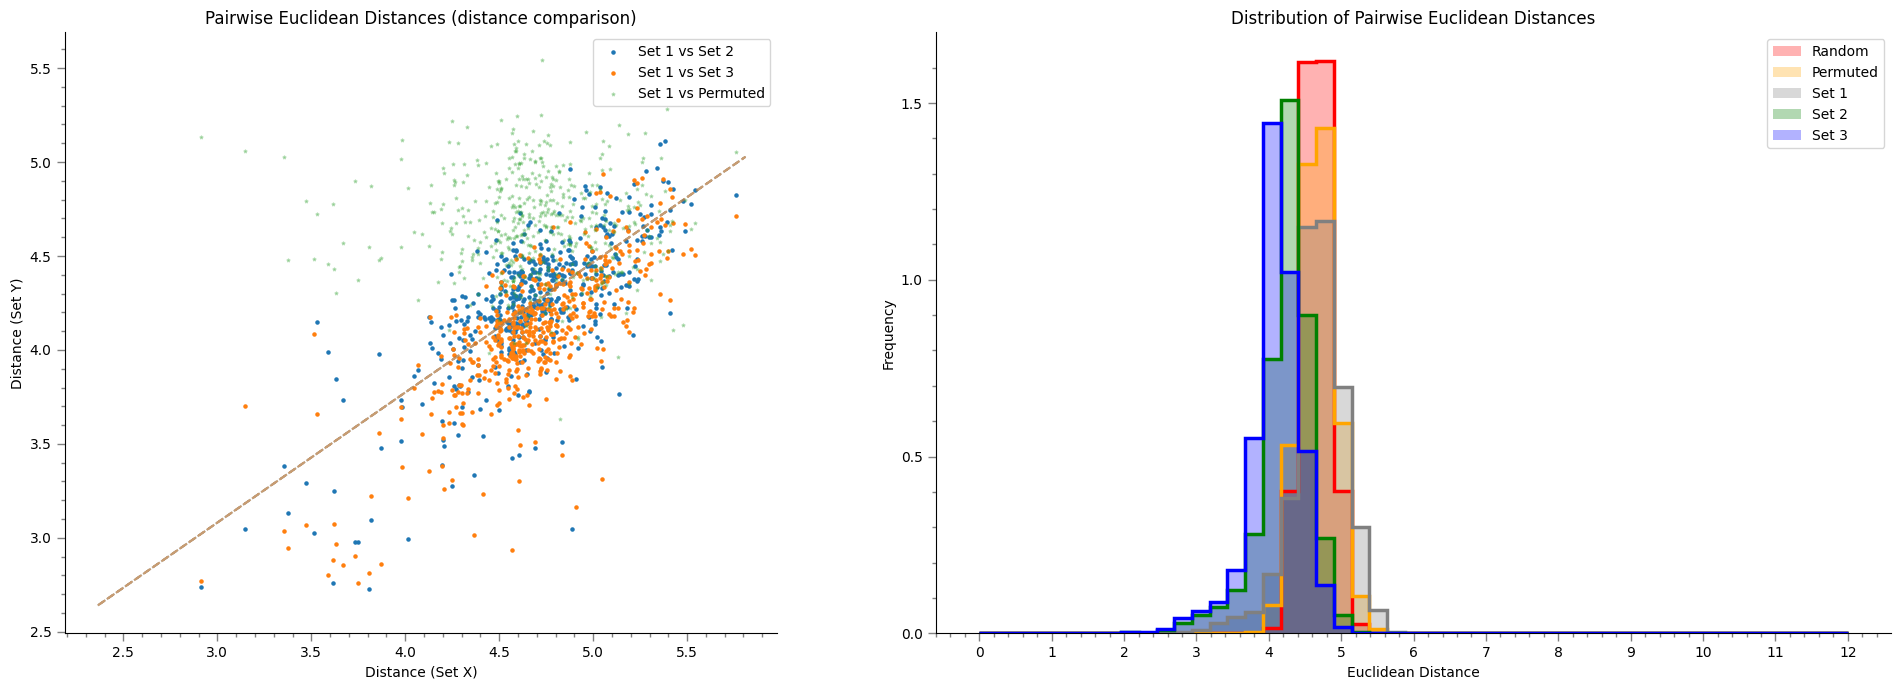

In [14]:
### Linear fit
coef_1 = np.polyfit(eucl_1[:max_points], eucl_2[:max_points], 1)
poly_1_fn = np.poly1d(coef_1)
### 
coef_2 = np.polyfit(eucl_1[:max_points], eucl_3[:max_points], 1)
poly_2_fn = np.poly1d(coef_1)

#####
fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_title("Pairwise Euclidean Distances (distance comparison)")
ax[0].set_xlabel("Distance (Set X)")
ax[0].set_ylabel("Distance (Set Y)")
ax[0].scatter(eucl_1[:max_points], eucl_2[:max_points], s=5)
ax[0].scatter(eucl_1[:max_points], eucl_3[:max_points], s=5)

ax[0].scatter(eucl_1[:max_points], eucl_p[:max_points], s=5, alpha=0.3, marker="*")
ax[0].legend(["Set 1 vs Set 2", "Set 1 vs Set 3", "Set 1 vs Permuted"])


ax[0].plot(eucl_1, poly_1_fn(eucl_1), linestyle="dashed", alpha = 0.5)
ax[0].plot(eucl_1, poly_2_fn(eucl_1), linestyle="dashed", alpha = 0.5)
ax[0].axis("scaled")

ax[0].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[0].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[0].xaxis.set_major_locator(MultipleLocator(0.5))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))


ax[1].set_title("Distribution of Pairwise Euclidean Distances")
ax[1].set_xlabel("Euclidean Distance")
ax[1].set_ylabel("Frequency")
bins = np.linspace(start=0, stop=12, num=50)

ax[1].hist(eucl_r, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="red")
ax[1].hist(eucl_p, density = True, bins=bins, histtype="stepfilled", alpha= 0.3, color="orange")
ax[1].hist(eucl_1, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="gray")
ax[1].hist(eucl_2, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="green")
ax[1].hist(eucl_3, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="blue")

ax[1].hist(eucl_r, density = True, bins=bins, histtype="step", linewidth=2.5, color="red")
ax[1].hist(eucl_p, density = True, bins=bins, histtype="step", linewidth=2.5, color="orange")
ax[1].hist(eucl_1, density = True, bins=bins, histtype="step", linewidth=2.5, color="gray")
ax[1].hist(eucl_2, density = True, bins=bins, histtype="step", linewidth=2.5, color="green")
ax[1].hist(eucl_3, density = True, bins=bins, histtype="step", linewidth=2.5, color="blue")

ax[1].legend([ "Random", "Permuted", "Set 1", "Set 2", "Set 3"])

ax[1].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[1].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[1].yaxis.set_major_locator(MultipleLocator(0.5))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))

plt.tight_layout()
sns.despine()
#plt.savefig(save_path + "/life_emb_pairwise_euclidean.svg", format="svg")
plt.show()

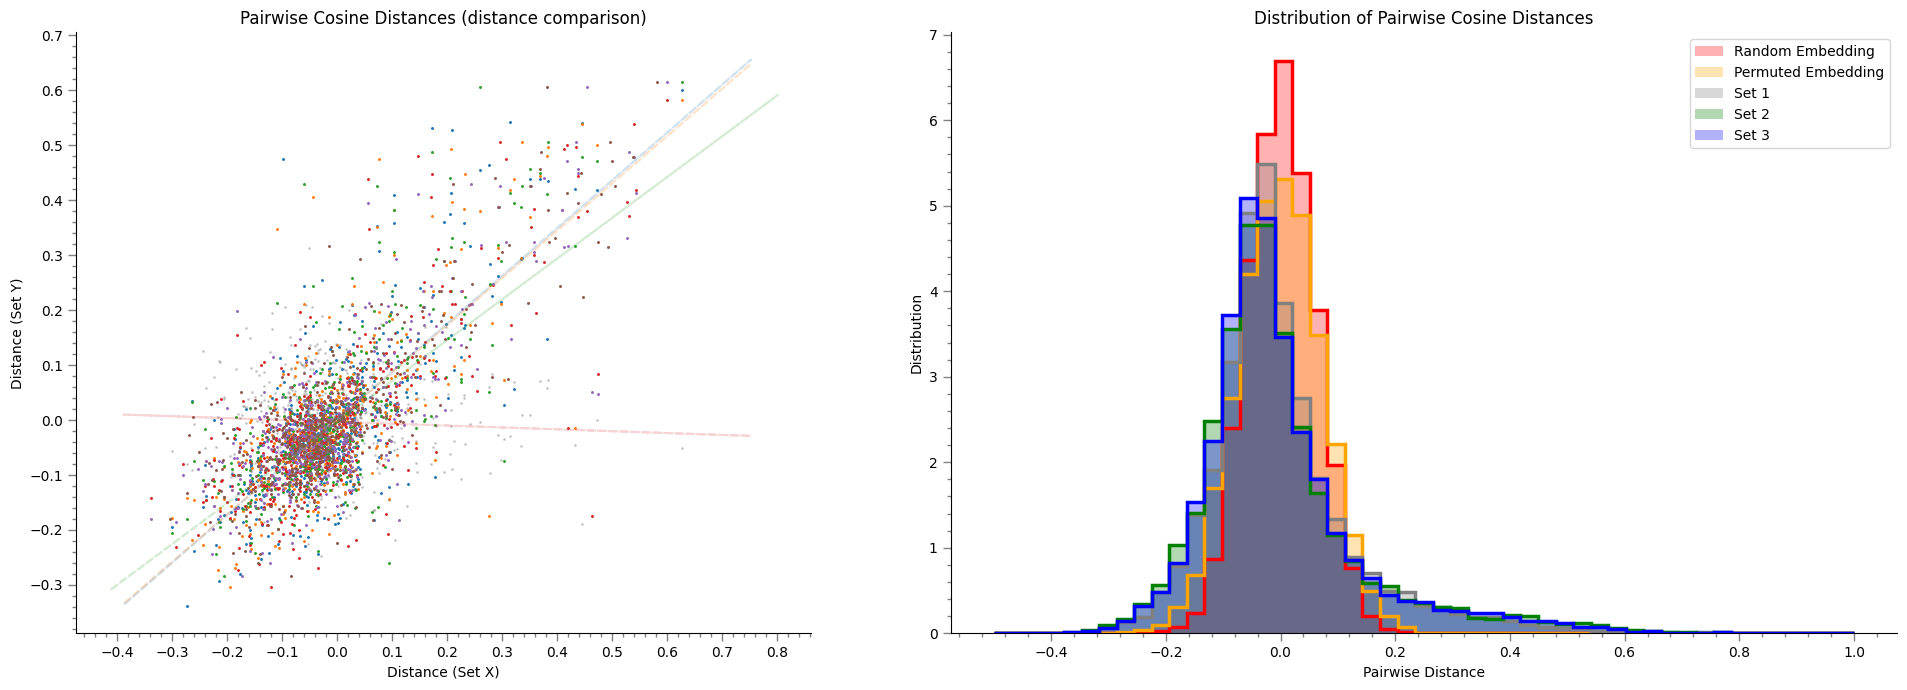

In [15]:
### Linear fit
coef_1 = np.polyfit(cos_1[:max_points], cos_2[:max_points], 1)
poly_1_fn = np.poly1d(coef_1)
### 
coef_2 = np.polyfit(cos_1[:max_points], cos_3[:max_points], 1)
poly_2_fn = np.poly1d(coef_2)
#####
coef_3 = np.polyfit(cos_2[:max_points], cos_3[:max_points], 1)
poly_3_fn = np.poly1d(coef_3)

#####
coef_4 = np.polyfit(cos_1[:max_points], cos_p[:max_points], 1)
poly_4_fn = np.poly1d(coef_4)


fig, ax = plt.subplots(1,2, figsize=(20,7))
ax[0].set_title("Pairwise Cosine Distances (distance comparison)")
ax[0].set_xlabel("Distance (Set X)")
ax[0].set_ylabel("Distance (Set Y)")
ax[0].scatter(cos_1[:max_points], cos_2[:max_points], marker=".", s=5)
ax[0].scatter(cos_1[:max_points], cos_3[:max_points], marker=".", s=5)
ax[0].scatter(cos_1[:max_points], cos_4[:max_points], marker=".", s=5)
ax[0].scatter(cos_2[:max_points], cos_3[:max_points], marker=".", s=5)
ax[0].scatter(cos_2[:max_points], cos_4[:max_points], marker=".", s=5)
ax[0].scatter(cos_3[:max_points], cos_4[:max_points], marker=".", s=5)
ax[0].scatter(cos_1[:max_points], cos_p[:max_points], alpha=0.3, s=5, marker=".", color="grey")
plt.legend(["Set 1 vs Set 2", "Set 1 vs Set 3", "Set 1 vs Set 4", "Set 2 vs Set 3", "Set 2 vs Set 4", "Set 3 vs Set 4", "Set 1 vs Permuted"])

ax[0].plot(cos_1, poly_1_fn(cos_1), linestyle="dashed", alpha = 0.2)
ax[0].plot(cos_1, poly_2_fn(cos_1), linestyle="dashed", alpha = 0.2)
ax[0].plot(cos_2, poly_3_fn(cos_2), linestyle="dashed", alpha = 0.2)
ax[0].plot(cos_1, poly_4_fn(cos_1), linestyle="dashed", alpha = 0.2)
ax[0].axis("scaled")


ax[1].set_title("Distribution of Pairwise Cosine Distances")
ax[1].set_xlabel("Pairwise Distance")
ax[1].set_ylabel("Distribution")

ax[0].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[0].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))

bins = np.linspace(start=-0.5, stop=1, num=50)

ax[1].hist(cos_r, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="red")
ax[1].hist(cos_p,  density = True, bins=bins, histtype="stepfilled", alpha= 0.3, color="orange")
ax[1].hist(cos_1, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="gray")
ax[1].hist(cos_2, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="green")
ax[1].hist(cos_3, density = True, bins=bins, histtype="stepfilled", alpha=0.3, color="blue")


ax[1].hist(cos_r, density = True, bins=bins, histtype="step", linewidth=2.5, color="red")
ax[1].hist(cos_p,  density = True, bins=bins, histtype="step", linewidth=2.5, color="orange")
ax[1].hist(cos_1, density = True, bins=bins, histtype="step", linewidth=2.5, color="gray")
ax[1].hist(cos_2, density = True, bins=bins, histtype="step", linewidth=2.5, color="green")
ax[1].hist(cos_3, density = True, bins=bins, histtype="step", linewidth=2.5, color="blue")

ax[1].legend(["Random Embedding", "Permuted Embedding", "Set 1", "Set 2", "Set 3"])

ax[1].tick_params(axis= "both", which="major", width=1, length = 6, direction="out", color="gray")
ax[1].tick_params(axis= "both", which="minor", width=1, length =3, direction="out", color="gray")

ax[1].yaxis.set_major_locator(MultipleLocator(1))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(5))

ax[1].xaxis.set_major_locator(MultipleLocator(0.2))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))

plt.tight_layout()
sns.despine()
#plt.savefig(save_path + "/life_emb_pairwise_cosine.svg", format="svg")
plt.show()

### Permutation Test (SStatistical Significance)
Comparing:c1 -> c2, c3, cr, cp

In [16]:
c1 = cosine_distances(embeddings[0])
c2 = cosine_distances(embeddings[1])
c3 = cosine_distances(embeddings[2])
c4 = cosine_distances(embeddings[3])
cp = cosine_distances(permuted)
cr = cosine_distances(randome)

In [17]:
print("%.4f" %stats.spearmanr(upper(c1), upper(c2)).correlation, 
      "%.4f" %stats.spearmanr(upper(c1), upper(c3)).correlation,
      "%.4f" %stats.spearmanr(upper(c1), upper(c4)).correlation,
      "%.4f" %stats.spearmanr(upper(c2), upper(c3)).correlation,
      "%.4f" %stats.spearmanr(upper(c2), upper(c4)).correlation,
      "%.4f" %stats.spearmanr(upper(c3), upper(c4)).correlation,
      "%.4f" % stats.spearmanr(upper(c4), upper(cp)).correlation,
      "%.4f" % stats.spearmanr(upper(c4), upper(cr)).correlation)

0.6295 0.6333 0.6259 0.6486 0.6623 0.6586 0.0009 -0.0005


In [19]:
def permutation_test(a, b, n_iter: int = 1000, hyp="greater"):
    """Nonparametric permutation testing Monte Carlo"""
    m1 = pd.DataFrame(a)
    m2 = pd.DataFrame(b)
    np.random.seed(0)
    rhos = []
    true_rho, _ = stats.spearmanr(upper(m1), upper(m2))
    # matrix permutation, shuffle the groups
    m_ids = list(m1.columns)
    m2_v = upper(m2)
    for i in tqdm(range(n_iter)):
        np.random.shuffle(m_ids) # shuffle list 
        r, _ = stats.spearmanr(upper(m1.loc[m_ids, m_ids]), m2_v)  
        rhos.append(r)
    if hyp == "greater":
        return (np.sum(true_rho <= rhos)+1)/(n_iter+1) 
    elif hyp == "less":
        return (np.sum(true_rho >= rhos)+1)/(n_iter+1)
    elif hyp=="two-sided":
        return (np.sum(np.abs(true_rho <= np.abs(rhos)))+1)/(n_iter+1), rhos # two-tailed test

In [20]:
clear_output()

print("1 vs 2")
p12 = permutation_test(c1,c2)
clear_output()
print(p12)

print("1 vs 3")
p13 = permutation_test(c1,c3)
clear_output()
print(p12, p13)

print("1 vs 4")
p14 = permutation_test(c1,c4)
clear_output()
print(p12, p13, p14)

print("2 vs 3")
p23 = permutation_test(c2,c3)
clear_output()
print(p12, p13, p14, p23)

print("2 vs 4")
p24 = permutation_test(c2,c4)
clear_output()
print(p12, p13, p14, p23, p24)

print("3 vs 4")
p34 = permutation_test(c3,c4)
clear_output()
print(p12, p13, p14, p23, p24, p34)

print("4 vs R")
p1r = permutation_test(c4,cr)
clear_output()
print(p12, p13, p14, p23, p24, p34, p1r)

print("4 vs P")
p1p = permutation_test(c4,cp)
clear_output()
print(p12, p13, p14, p23, p24, p34, p1r, p1p)

0.000999000999000999 0.000999000999000999 0.000999000999000999 0.000999000999000999 0.000999000999000999 0.000999000999000999 0.6213786213786214 0.2967032967032967


In [26]:
p12

0.0001999600079984003

In [21]:
p_vals = [p12, p13, p14, p23, p24, p34, p1r, p1p]
p_vals 

[0.000999000999000999,
 0.000999000999000999,
 0.000999000999000999,
 0.000999000999000999,
 0.000999000999000999,
 0.000999000999000999,
 0.6213786213786214,
 0.2967032967032967]

In [22]:
labels = ["1 vs 2", "1 vs 3", "1 vs 4", "2 vs 3", "2 vs 4", "3 vs 4", "4 vs R", "4 vs P"]
reject, p_corr, alpha_sidak, alpha_bf  = multipletests(p_vals, method="fdr_bh")
for i in range(len(labels)):
    print("%s (p = %.6f) || Reject: %s" %(labels[i], p_corr[i], reject[i]))

1 vs 2 (p = 0.001332) || Reject: True
1 vs 3 (p = 0.001332) || Reject: True
1 vs 4 (p = 0.001332) || Reject: True
2 vs 3 (p = 0.001332) || Reject: True
2 vs 4 (p = 0.001332) || Reject: True
3 vs 4 (p = 0.001332) || Reject: True
4 vs R (p = 0.621379) || Reject: False
4 vs P (p = 0.339089) || Reject: False


In [ ]:
#### ADDITIONAL TESTS

e_add = []
paths = [r".../logs/v15/pre_training/version_1.33/00029/token_embeddings/tensors.tsv",
         r".../logs/v15/pre_training/version_6.0/00029/token_embeddings/tensors.tsv", 
         r".../logs/v15/pre_training/version_6.1/00029/token_embeddings/tensors.tsv",
         r".../logs/v15/pre_training/version_6.2/00029/token_embeddings/tensors.tsv",
         r".../logs/v15/pre_training/version_6.3/00029/token_embeddings/tensors.tsv",

        ]
for path in paths:
    e = pd.read_csv(path, sep="\t", header=None).values
    mu = e.sum(0) / (vocab.shape[0] - 6)
    e_add.append(e - mu)
c_orig = cosine_distances(e_add[0])
c_b1   = cosine_distances(e_add[1])
c_b2   = cosine_distances(e_add[2])
c_b3   = cosine_distances(e_add[3])
c_b4   = cosine_distances(e_add[-1])

In [ ]:
p_vals_b = [permutation_test(c_orig, c_b1), permutation_test(c_orig, c_b2), permutation_test(c_orig, c_b3), permutation_test(c_orig, c_b4)]
print(p_vals_b)


In [ ]:
corr = [stats.spearmanr(upper(c_orig), upper(c_b1)).correlation, 
        stats.spearmanr(upper(c_orig), upper(c_b2)).correlation,
        stats.spearmanr(upper(c_orig), upper(c_b3)).correlation,
        stats.spearmanr(upper(c_orig), upper(c_b4)).correlation]
corr

In [ ]:
reject, p_corr, alpha_sidak, alpha_bf  = multipletests(p_vals_b, method="fdr_bh")
labels = [ "b1", "b2", "b3", "b4"]
for i in range(len(labels)):
    print("%s corr: %.3f (p = %.4f) || Reject: %s" %(labels[i], corr[i], p_corr[i], reject[i]))

In [ ]:
from glob import glob

In [ ]:
orig_paths = glob(".../logs/v15/pre_training/version_1.33/*/token_embeddings/tensors.tsv")
orig_add = []
for path in orig_paths:
    e = pd.read_csv(path, sep="\t", header=None).values
    mu = e.sum(0) / (vocab.shape[0] - 6)
    orig_add.append(e - mu)
    
corr_list = []
for i in range(len(orig_paths)):
    dl = cosine_distances(orig_add[-1])
    dn = cosine_distances(orig_add[i])
    corr_list.append(stats.spearmanr(upper(dl), upper(dn)).correlation)
    